<h2>Setup</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.options.display.max_columns = 999
pd.options.display.max_rows = 100
from scipy import stats

In [3]:
dca = pd.read_csv('../src/dca_291118.csv')
dla_1 = pd.read_csv('../src/LTE-FDD_traffic_Grid_2018113009523030927/LTE-FDD_traffic_Grid_2018113009523030927.csv')
dla_2 = pd.read_csv('../src/LTE-FDD_traffic_Grid_2018113009523030927/LTE-FDD_traffic_Grid_2018113009523030927_1.csv')
dla = pd.concat([dla_1,dla_2],axis=0)
del dla_1,dla_2

In [4]:
dca.set_index(['Latitude','Longitude'],inplace=True)
dla.set_index(['Latitude','Longitude'],inplace=True)

In [5]:
df = dca.join(dla,how='inner',lsuffix='_dca',rsuffix='_dla')

In [6]:
del dca,dla

In [7]:
bins = pd.IntervalIndex.from_tuples([(-135,-125),(-125,-115),(-115,-105),(-105,-95),(-95,-85),(-85,-75),(-75,-65),(-65,-55)])
df['suppress traffic bin'] = pd.cut(df['RSRP(All MRs) (dBm)'],bins=bins,labels=['(-135,-125)','(-125,-115)','(-115,-105)','(-105,-95)','(-95,-85)','(-85,-75)','(-75,-65)','(-65,-55)'],include_lowest=True)

In [8]:
print('Sum MR count dca:',df['MR Count_dca'].sum())
print('Sum MR count dla:',df['MR Count_dla'].sum())

Sum MR count dca: 7108400890
Sum MR count dla: 2872532393


In [9]:
df = df[['RSRP(All MRs) (dBm)','Total Traffic Volume (MB)','suppress traffic bin','MR Count_dca']]

In [10]:
df.reset_index(inplace=True)
df.head()

,Latitude,Longitude,RSRP(All MRs) (dBm),Total Traffic Volume (MB),suppress traffic bin,MR Count_dca
0,13.461036,100.858384,-103.0,0.040,"(-105, -95]",1
1,13.461486,100.848189,-95.0,0.006,"(-105, -95]",1
2,13.461486,100.851897,-104.0,0.000,"(-105, -95]",1
3,13.461486,100.863018,-83.5,0.766,"(-85, -75]",2
4,13.461935,100.864408,-94.0,0.000,"(-95, -85]",1


In [11]:
df['Traffic per MR (MB)'] = df['Total Traffic Volume (MB)']/df['MR Count_dca']

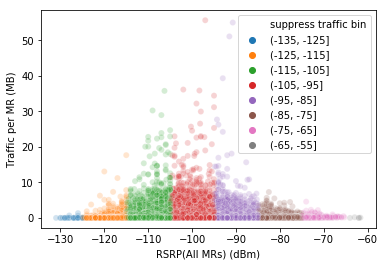

In [13]:
sns.scatterplot('RSRP(All MRs) (dBm)','Traffic per MR (MB)',data=df,alpha=0.2,hue='suppress traffic bin')

In [11]:
traff_target = df[df['suppress traffic bin']==bins[5]]['Total Traffic Volume (MB)'].values

df_est_all = pd.DataFrame(data=None,columns=df.columns.tolist()+['pct','est_traff'])
for idx in range(8):
    
    sub_df = df[df['suppress traffic bin']==bins[idx]]
    if idx<5:
        traff = sub_df['Total Traffic Volume (MB)'].values
        pct_t = stats.rankdata(traff, 'min')/len(traff)*100
        est_traff = np.percentile(traff_target,pct_t)
        sub_df['pct'] = pct_t
        sub_df['est_traff'] = est_traff
    else:
        sub_df['pct'] = 999
        sub_df['est_traff'] = sub_df['Total Traffic Volume (MB)']
    
    df_est_all = pd.concat([df_est_all,sub_df],axis=0)

/Users/witchapong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/witchapong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/witchapong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [12]:
print(df.shape)
print(df_est_all.shape)

(1907158, 6)
(1907158, 8)


In [13]:
df_est_all['traffic_gain'] = df_est_all['est_traff'] - df_est_all['Total Traffic Volume (MB)']
df_est_all['traffic_gain'] = df_est_all['traffic_gain'].apply(lambda x:max(0,x))

In [14]:
df_est_all.reset_index(drop=True,inplace=True)

In [15]:
df_est_all.head()

,Latitude,Longitude,RSRP(All MRs) (dBm),Total Traffic Volume (MB),suppress traffic bin,MR Count_dca,pct,est_traff,traffic_gain
0,13.499707,100.716584,-128.26,0.258,"(-135, -125]",46,89.655172,11924.334310,11924.076310
1,13.499707,100.717048,-130.00,0.000,"(-135, -125]",46,3.448276,11.131828,11.131828
2,13.503754,100.891285,-127.00,0.003,"(-135, -125]",1,65.517241,3353.028207,3353.025207
3,13.505103,100.457081,-130.00,0.000,"(-135, -125]",1,3.448276,11.131828,11.131828
4,13.507351,100.458471,-129.00,0.001,"(-135, -125]",1,48.275862,1720.531241,1720.530241


<h2>Visualization and proof of assumption</h2>

In [31]:
df.head()

RSRP(All MRs) (dBm)  Total Traffic Volume (MB)  \
Latitude  Longitude                                                    
13.461036 100.858384               -103.0                      0.040   
13.461486 100.848189                -95.0                      0.006   
          100.851897               -104.0                      0.000   
          100.863018                -83.5                      0.766   
13.461935 100.864408                -94.0                      0.000   

                     suppress traffic bin  
Latitude  Longitude                        
13.461036 100.858384          (-105, -95]  
13.461486 100.848189          (-105, -95]  
          100.851897          (-105, -95]  
          100.863018           (-85, -75]  
13.461935 100.864408           (-95, -85]

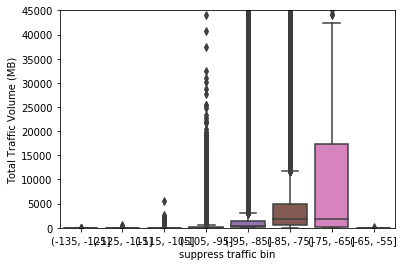

In [23]:
# create the plot for traffic distribution per rsrp range
import seaborn as sns
sns.boxplot(x='suppress traffic bin',y='Total Traffic Volume (MB)',data=df)
_=plt.ylim([0,4.5e4])

In [68]:
np.sum(~df['outlier'] | df['outlier'])

1907158

In [69]:
def is_outlier(x):
    q1 = np.percentile(x,25)
    q3 = np.percentile(x,75)
    iqr = q3-q1
    min_val = q1-1.5*iqr
    max_val = q3+1.5*iqr
    return ((x<min_val) | (x>max_val))

df["outlier"] = df.groupby("suppress traffic bin")["Total Traffic Volume (MB)"].transform(is_outlier)

In [75]:
print(df.shape)
df_filtered = df[~df.outlier]
print(df.shape)

(1907158, 5)
(1907158, 5)


In [76]:
df_filtered["norm_by_bin_traffic"]=df_filtered.groupby("suppress traffic bin")["Total Traffic Volume (MB)"]\
.transform(lambda x:(x-np.min(x))/(np.max(x)-np.min(x))*100)

/Users/witchapong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


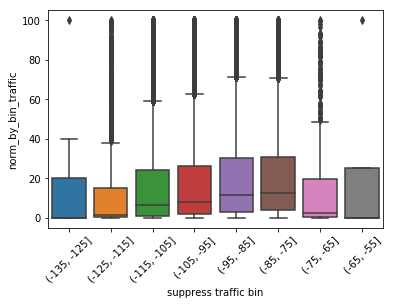

In [80]:
sns.boxplot(x='suppress traffic bin',y='norm_by_bin_traffic',data=df_filtered)
_=plt.xticks(rotation=45)

/Users/witchapong/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


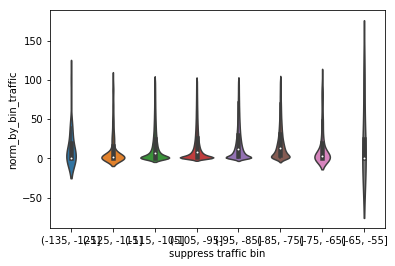

In [78]:
sns.violinplot(x='suppress traffic bin',y='norm_by_bin_traffic',data=df_filtered)

In [44]:
# create a normalized cdf of traffic for each RSRP range
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort((data-np.min(data))/(np.max(data)-np.min(data))*100)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

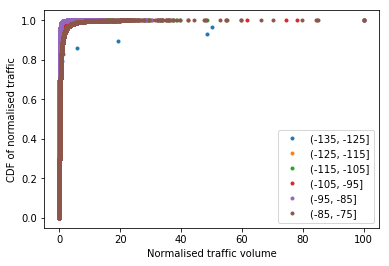

In [48]:
for i in range(6):
    
    # Compute ECDF for versicolor data: x_vers, y_vers
    x, y = ecdf(df[df['suppress traffic bin']==bins[i]]['Total Traffic Volume (MB)'].values)

    # Generate plot
    _ = plt.plot(x,y,marker='.',linestyle='none',label=bins[i])

_ = plt.xlabel('Normalised traffic volume')
_ = plt.ylabel('CDF of normalised traffic')
_ = plt.legend()

<h2>Map traffic estimation to PA areas</h2>

In [11]:
import fiona
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
pa = fiona.open("../files/shape files/RNC_PA_region.shp")

pa_poly = [Polygon(item['geometry']['coordinates'][0]) for item in pa]

In [ ]:
from tqdm import tqdm
tqdm.pandas()

def map_coor2cid(x):
    point = Point(x['Longitude'],x['Latitude'])
    for i,pa in enumerate(pa_poly):
        if pa.contains(point):
            return i
        
df_low_all['pa_id'] = df_low_all.progress_apply(map_coor2cid,axis=1)

In [ ]:
# calculate pa area
import pyproj
from functools import partial
from shapely.ops import transform
from shapely.geometry import shape

def cal_pa_area(x):
    geom = Polygon(pa_poly[x])
    s = shape(geom)
    proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),
                   pyproj.Proj(init='epsg:3857'))

    s_new = transform(proj, s)

    return transform(proj, s).area

In [ ]:
df_low_all['traffic_gain'] = df_low_all['est_traff'] - df_low_all['Total Traffic Volume (MB)']

pa_sum_df = pd.DataFrame(df_low_all.groupby('pa_id')['traffic_gain'].sum()).reset_index()
pa_sum_df['pa_id'] = pa_sum_df['pa_id'].astype(int)
pa_sum_df['pa_area'] = pa_sum_df['pa_id'].apply(cal_pa_area)

pa_sum_df['traffic gain/area (MB/m^2)'] = pa_sum_df['traffic_gain']/pa_sum_df['pa_area']

In [ ]:
pred_traff = pa_sum_df['traffic_gain'].values

import numpy as np
norm_pred_traff = (pred_traff - np.min(pred_traff))/(np.max(pred_traff)-np.min(pred_traff))

lng_list = []
lat_list = []
alpha_list = []
for i,pa_id in enumerate(pa_sum_df['pa_id']):
    lng=[]
    lat=[]
    for coor in pa[pa_id]['geometry']['coordinates'][0]:
        lng.append(coor[0])
        lat.append(coor[1])
    lng_list.append(lng)
    lat_list.append(lat)
    alpha_list.append(norm_pred_traff[i])

from bokeh.io import output_file,show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

source = ColumnDataSource(data = dict(
    pa_id = pa_sum_df['pa_id'].values,
    lng = lng_list,
    lat = lat_list,
    al = alpha_list,
    traff = pred_traff
))
plot = figure(plot_width=1000,title='predicted traffic gain(MB) from coverage improvement of each PA(Problem Area)')
plot.patches('lng','lat',alpha='al',source=source)

hover = HoverTool(tooltips=[('pa id', '@pa_id'),('predicted traffic gain (MB)', '@traff')])
plot.add_tools(hover)

output_file('../out/pa.html')
show(plot)

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go

# Create traces
trace0 = go.Scatter(
    x = pa_sum_df['traffic_gain'].values,
    y = pa_sum_df['traffic gain/area (MB/m^2)'].values,
    mode = 'markers',
    name = 'PA ID',
    text = pa_sum_df['pa_id']
)
trace1 = go.Scatter(
    x = [np.min(pa_sum_df['traffic_gain'].values),np.max(pa_sum_df['traffic_gain'].values)],
    y = [np.median(pa_sum_df['traffic gain/area (MB/m^2)'].values),np.median(pa_sum_df['traffic gain/area (MB/m^2)'].values)],
    mode = 'lines',
    line = dict(color = 'red')
)
trace2 = go.Scatter(
    x = [np.median(pa_sum_df['traffic_gain'].values),np.median(pa_sum_df['traffic_gain'].values)],
    y = [np.min(pa_sum_df['traffic gain/area (MB/m^2)'].values),np.max(pa_sum_df['traffic gain/area (MB/m^2)'].values)],
    mode = 'lines',
    line = dict(color = 'red')
)

data = [trace0, trace1, trace2]

layout= go.Layout(
    title= 'PA total traffic gain and traffic gain per area estimation',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Total traffic gain (MB)',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Traffic gain per area (MB/m^2)',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)

fig= go.Figure(data=data, layout=layout)
py.iplot(fig)

<h2>Potential area searching using 2D convolutional filter</h2>

In [20]:
est_traff_mat=pd.crosstab(df_est_all.Latitude,df_est_all.Longitude,values=df_est_all.traffic_gain,aggfunc=sum).fillna(0)

In [21]:
est_traff_mat.shape

(1861, 1587)

In [22]:
lat = est_traff_mat.index
lon = est_traff_mat.columns

In [25]:
# define example filter of size 8x8
cov_filter = np.empty((8,8),dtype=float)
cov_filter.fill(0.5)

cov_filter[1:-1,1:-1] = 0.7

cov_filter[2:-2,2:-2] = 0.9

cov_filter[3:-3,3:-3] = 1

In [28]:
from scipy.signal import convolve2d

Some example for 2D convolution function from Scipy

In [29]:
array=np.ones((8,8))
kernel=np.array([[1,2,3],[4,5,6]])
display(array)
display(kernel)
convolve2d(array,kernel)

array([[1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.]])

array([[1, 2, 3],
       [4, 5, 6]])

array([[ 1.,  3.,  6.,  6.,  6.,  6.,  6.,  6.,  5.,  3.],
       [ 5., 12., 21., 21., 21., 21., 21., 21., 16.,  9.],
       [ 5., 12., 21., 21., 21., 21., 21., 21., 16.,  9.],
       [ 5., 12., 21., 21., 21., 21., 21., 21., 16.,  9.],
       [ 5., 12., 21., 21., 21., 21., 21., 21., 16.,  9.],
       [ 5., 12., 21., 21., 21., 21., 21., 21., 16.,  9.],
       [ 5., 12., 21., 21., 21., 21., 21., 21., 16.,  9.],
       [ 5., 12., 21., 21., 21., 21., 21., 21., 16.,  9.],
       [ 4.,  9., 15., 15., 15., 15., 15., 15., 11.,  6.]])

In [41]:
# x_edge = cov_filter.shape[1]
# y_edge = cov_filter.shape[0]
agg_traff = convolve2d(est_traff_mat,cov_filter,'valid')

In [42]:
agg_traff.shape, est_traff_mat.shape

((1854, 1580), (1861, 1587))

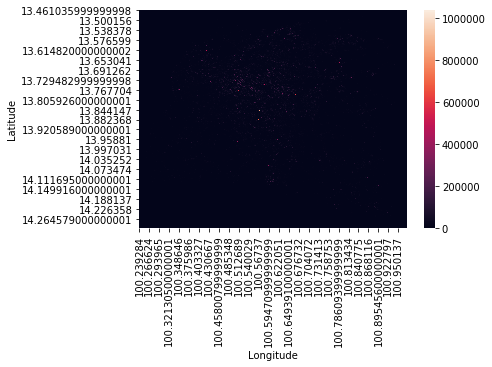

In [43]:
import seaborn as sns
_ = sns.heatmap(est_traff_mat)

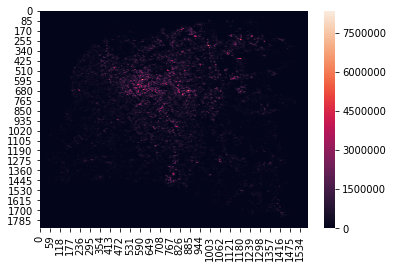

In [44]:
_ = sns.heatmap(agg_traff)

In [23]:
# grad=np.gradient(agg_traff)

# grad_mag = np.sqrt(grad[0]**2 + grad[1]**2)

# _ = sns.heatmap(grad_mag)

# grad_mag[grad_mag==0]=999_999_999

# # find the top 10 spot for new sites
# topn_index_1d = list(np.argsort(grad_mag.reshape(-1))[:10])

# # convert the 1d index back to 2d index
# topn_index_2d = [(idx//grad_mag.shape[1],idx%grad_mag.shape[1]) for idx in topn_index_1d]

In [87]:
lat = est_traff_mat.index
lon = est_traff_mat.columns

coordinate: (13.534106000000001,100.634331), traffic gain:5069583.784104824
coordinate: (13.562434499999998,100.82154399999999), traffic gain:4378165.423907354
coordinate: (13.575474500000002,100.791423), traffic gain:5509413.637442326
coordinate: (13.5970585,100.7024505), traffic gain:6255084.135514915
coordinate: (13.627634999999998,100.755741), traffic gain:4884101.572269066
coordinate: (13.64742,100.7895695), traffic gain:6516314.863400744
coordinate: (13.671251999999999,100.68067099999999), traffic gain:4068469.499665485
coordinate: (13.692386500000001,100.591698), traffic gain:7954709.410157744
coordinate: (13.692386500000001,100.750644), traffic gain:3566650.148183858
coordinate: (13.693285499999998,100.638038), traffic gain:4169474.2902784008
coordinate: (13.718017,100.7826185), traffic gain:3677056.178211887
coordinate: (13.728808999999998,100.523579), traffic gain:6910920.730811375
coordinate: (13.745896000000002,100.511067), traffic gain:7503566.481665562
coordinate: (13.745

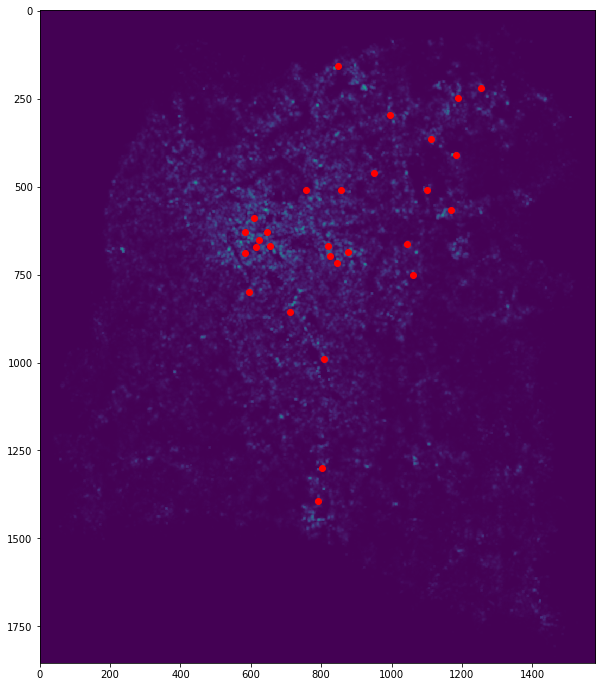

In [99]:
import numpy as np
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import matplotlib.pyplot as plt

conf_size = 8

#fname = '/tmp/slice0000.png'
neighborhood_size = 5
threshold = 1_500_000

data = agg_traff

data_max = filters.maximum_filter(data, neighborhood_size)
maxima = (data == data_max)
data_min = filters.minimum_filter(data, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0

labeled, num_objects = ndimage.label(maxima)
slices = ndimage.find_objects(labeled)
x, y = [], []
for dy,dx in slices:
    x_center = (dx.start + dx.stop - 1)/2
    x.append(int(x_center))
    y_center = (dy.start + dy.stop - 1)/2    
    y.append(int(y_center))


plt.figure(figsize=(12,12))
plt.imshow(data)
#plt.savefig('/tmp/data.png', bbox_inches = 'tight')

plt.autoscale(False)
plt.plot(x,y, 'ro')
#plt.savefig('/tmp/result.png', bbox_inches = 'tight')

# get the corresponding traffic + coordinates
lat_res = []
lon_res = []
traff_res = []
for i,j in zip(y,x):
    print(f'coordinate: ({(lat[i]+lat[i+conf_size-1])/2},{(lon[j]+lon[j+conf_size-1])/2}), traffic gain:{agg_traff[i,j]}')
    lat_res.append((lat[i]+lat[i+conf_size-1])/2)
    lon_res.append((lon[j]+lon[j+conf_size-1])/2)
    traff_res.append(agg_traff[i,j])

In [104]:
# export the result
pred_coord = pd.DataFrame({'lat':lat_res,'lon':lon_res,'coverage_traffic_gain':traff_res}).sort_values('coverage_traffic_gain',ascending=False)
pred_coord.to_csv('../out/pred_coord.csv',index=False)

In [105]:
pred_coord

,lat,lon,coverage_traffic_gain
28,14.090336,100.607917,8.336533e+06
7,13.692387,100.591698,7.954709e+06
12,13.745896,100.511067,7.503566e+06
20,13.772875,100.511530,6.999913e+06
11,13.728809,100.523579,6.910921e+06
19,13.771976,100.646379,6.688896e+06
5,13.647420,100.789569,6.516315e+06
3,13.597058,100.702450,6.255084e+06
2,13.575475,100.791423,5.509414e+06
22,13.785466,100.632477,5.297423e+06
